Using device: cuda
Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/Normal-1988.png
True Label: NORMAL
Predicted Label: NORMAL



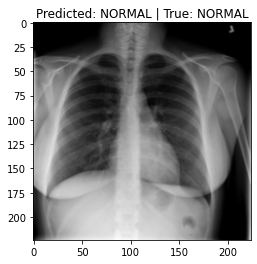

Image: /home/khare.aks/Dataset/combined/PNEUMONIA/PNEUMONIA/BACTERIA-2793790-0003.jpeg
True Label: PNEUMONIA
Predicted Label: PNEUMONIA



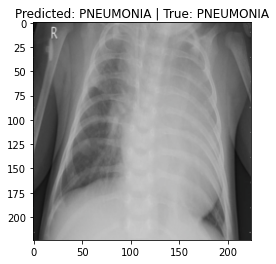

Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/Normal-802.png
True Label: NORMAL
Predicted Label: NORMAL



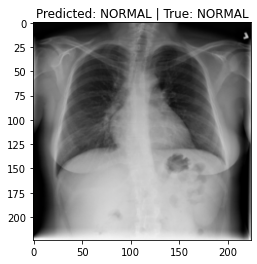

Image: /home/khare.aks/Dataset/combined/COVID/COVID/COVID_1544.png
True Label: COVID
Predicted Label: COVID



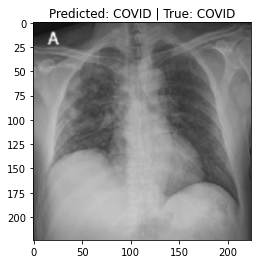

Image: /home/khare.aks/Dataset/combined/PNEUMONIA/PNEUMONIA/BACTERIA-2899476-0001.jpeg
True Label: PNEUMONIA
Predicted Label: PNEUMONIA



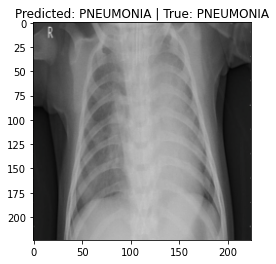

Image: /home/khare.aks/Dataset/combined/Tuberculosis/Tuberculosis/Tuberculosis-313.png
True Label: Tuberculosis
Predicted Label: Tuberculosis



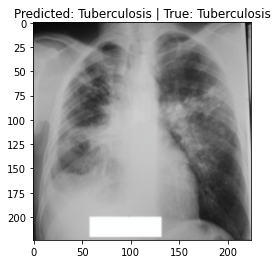

Image: /home/khare.aks/Dataset/combined/COVID/COVID/COVID_807.png
True Label: COVID
Predicted Label: COVID



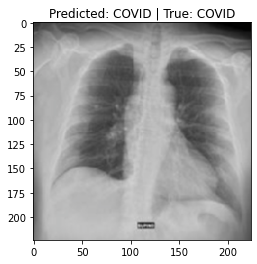

Image: /home/khare.aks/Dataset/combined/Tuberculosis/Tuberculosis/tb0142.png
True Label: Tuberculosis
Predicted Label: Tuberculosis



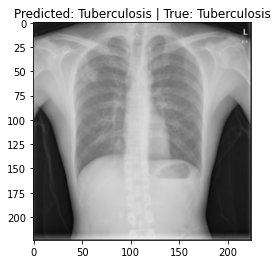

Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/Normal-356.png
True Label: NORMAL
Predicted Label: NORMAL



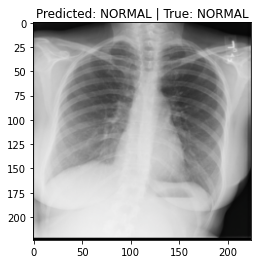

Image: /home/khare.aks/Dataset/combined/NORMAL/NORMAL/NORMAL-7397628-0002.jpeg
True Label: NORMAL
Predicted Label: NORMAL



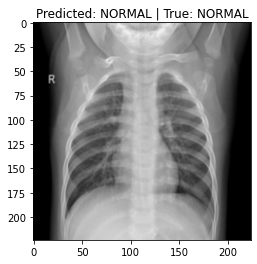

In [ ]:
# Imports
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

# Device Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data Preparation
data_dir = 'location of the data set in your system, please download it from the drive link mentioned in the readme file'
image_paths, labels = [], []

# Load Image Paths and Labels
for folder in os.listdir(data_dir):
    outer_folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(outer_folder_path):
        inner_folder_path = os.path.join(outer_folder_path, folder)
        if os.path.isdir(inner_folder_path):
            for file in os.listdir(inner_folder_path):
                if file.endswith(('.jpg', '.png', '.jpeg')):
                    image_paths.append(os.path.join(inner_folder_path, file))
                    labels.append(folder)

# Create DataFrame
data_frame = pd.DataFrame({'image_paths': image_paths, 'labels': labels})

# Split Dataset
strat = data_frame['labels']

# First split: train and temp (validation + test)
train_df, temp_df = train_test_split(
    data_frame, 
    train_size=0.8, 
    shuffle=True, 
    random_state=123, 
    stratify=strat
)

# Second split: validation and test
strat_temp = temp_df['labels']
valid_df, test_df = train_test_split(
    temp_df, 
    train_size=0.5, 
    shuffle=True, 
    random_state=123, 
    stratify=strat_temp
)

# Label Mappings
unique_labels = data_frame['labels'].unique()
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_class = {v: k for k, v in label_mapping.items()}

# DenseNet Model Definition
class DenseNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetClassifier, self).__init__()
        self.model = models.densenet121(weights=None)
        num_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.model(x)

# Load DenseNet Model
num_classes = len(label_mapping)
densenet_model = DenseNetClassifier(num_classes).to(device)
densenet_checkpoint = torch.load('densenet_chest_xray_1.pth', map_location=device)
densenet_model.load_state_dict(densenet_checkpoint['model_state_dict'])
densenet_model.eval()

# Image Transform
demo_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Inference Code
demo_images = test_df.sample(n=10, random_state=42)

densenet_model.eval()
with torch.no_grad():
    for idx, row in demo_images.iterrows():
        img_path = row['image_paths']
        true_label = row['labels']
        
        # Open and Transform Image
        img = Image.open(img_path).convert('RGB')
        img_t = demo_transform(img).unsqueeze(0).to(device)

        # Perform Inference
        output = densenet_model(img_t)
        _, pred = torch.max(output, 1)
        pred_label = idx_to_class[pred.item()]

        # Print Results
        print(f"Image: {img_path}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {pred_label}\n")

        # Display Image with Prediction and True Label
        img_np = img_t.cpu().squeeze().numpy()
        img_np = np.transpose(img_np, (1, 2, 0)) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)
        plt.imshow(img_np)
        plt.title(f"Predicted: {pred_label} | True: {true_label}")
        plt.show()
